In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
fibrosis_ultrasound_images_path = kagglehub.dataset_download('vibhingupta028/liver-histopathology-fibrosis-ultrasound-images')

print(f'Data source import complete. path - {fibrosis_ultrasound_images_path}')


Data source import complete. path - /kaggle/input/liver-histopathology-fibrosis-ultrasound-images


In [2]:
!ls '{fibrosis_ultrasound_images_path}'

Dataset


### ***What is Liver Fibrosis?***
****
A condition where liver tissue becomes scarred due to prolonged inflammation or damage, affecting liver function and potentially leading to severe complications if untreated***.



In [2]:
# Imports
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!mv '{fibrosis_ultrasound_images_path}/' '/content/sample_data'

In [6]:

# Paths
#BASE_DIR = '/content/sample_data/2/Dataset/Dataset/'
BASE_DIR = '/content/sample_data/liver-histopathology-fibrosis-ultrasound-images'
DATASET_PATH = f"{BASE_DIR}/Dataset/Dataset"

!ls -l {DATASET_PATH}

ls: cannot access '/content/sample_data/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset': No such file or directory


In [7]:
def create_3_classes():
  import os
  import shutil

  base_dir = DATASET_PATH
  output_dir = os.path.join(base_dir, '3')
  normal_dir = os.path.join(output_dir, 'Normal')
  fibrosis_dir = os.path.join(output_dir, 'Fibrosis')
  cirrhosis_dir = os.path.join(output_dir, 'Cirrhosis')

  # Create output directories if they don't exist
  os.makedirs(normal_dir, exist_ok=True)
  os.makedirs(fibrosis_dir, exist_ok=True)
  os.makedirs(cirrhosis_dir, exist_ok=True)

  # Function to move and rename files
  def move_and_rename(source_dir, target_dir, prefix, start_index=1, second_index=None):
      count = start_index
      second_part = 1 if second_index is None else second_index
      for filename in os.listdir(source_dir):
          if os.path.isfile(os.path.join(source_dir, filename)):
              file_ext = os.path.splitext(filename)[1]
              if second_index is None:
                  new_filename = f"{prefix}_{count}{file_ext}"
              else:
                  new_filename = f"{prefix}_{count}_{second_part}{file_ext}"
              shutil.move(os.path.join(source_dir, filename), os.path.join(target_dir, new_filename))
              count += 1

  # Move and rename files for F0 (Normal)
  move_and_rename(os.path.join(base_dir, 'F0'), normal_dir, 'Normal')

  # Move and rename files for F1, F2, F3 (Fibrosis)
  move_and_rename(os.path.join(base_dir, 'F1'), fibrosis_dir, 'Fibrosis', second_index=1)
  move_and_rename(os.path.join(base_dir, 'F2'), fibrosis_dir, 'Fibrosis', second_index=2)
  move_and_rename(os.path.join(base_dir, 'F3'), fibrosis_dir, 'Fibrosis', second_index=3)

  # Move and rename files for F4 (Cirrhosis)
  move_and_rename(os.path.join(base_dir, 'F4'), cirrhosis_dir, 'Cirrhosis')

  print("Data movement and renaming complete.")

In [8]:
#!ls -l '{DATASET_PATH}/Normal/'
#!ls -l '{DATASET_PATH}/Fibrosis/'
#!ls -l '{DATASET_PATH}/Cirrhosis/'
!find '{DATASET_PATH}' -type f | wc -l

6323


#Config

In [7]:
CONFIG = {
    'data_dir': DATASET_PATH, # e.g., 'data/liver_fibrosis/'
    'train': True,
    'labels_file': 'dataset_details.csv', # e.g., 'data/labels.csv'
    'pretrained_model_path': '/content/sample_data/DenseNet121.pt', # Replace with your downloaded model path
    'image_size': 300, # Densenet121 typically expects 224x224 input
    'batch_size': 16,
    'training_patience': 5,
    'num_epochs': 2, # Adjust as needed
    'learning_rate': 1e-5, # Start with a small learning rate for fine-tuning
    'num_classes': 5, # F0, F1, F2, F3, F4
    'class_labels': ['F0', 'F1', 'F2', 'F3', 'F4'],
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'output_model_path': '/content/sample_data/liver_fibrosis.pt',
    'training_metrics_json': 'training_metrics.json',
}



# EDA on dataset

## Read dataset

In [10]:
# prompt: Generate code to read dataset from DATASET_PATH only without any transformation, the transformation needs to be done later if the file '"dataset_details.csv" doesn't exists. Show classes found and its label mapping.

import os
from torchvision import datasets

# Check if the dataset_details.csv file exists
dataset_details_file = CONFIG["labels_file"]
if not os.path.exists(dataset_details_file):
    # Read the dataset without transformations
    dataset = datasets.ImageFolder(root=DATASET_PATH)

    # Show classes found and their label mapping
    print("Classes found:")
    print(dataset.classes)
    print("\nLabel mapping:")
    print(dataset.class_to_idx)

else:
    # If the file exists, you would typically load details from it
    # and then proceed with transformations based on that information.
    # For this task, we are only handling the case where the file doesn't exist.
    print(f"{dataset_details_file} exists.")


Classes found:
['F0', 'F1', 'F2', 'F3', 'F4']

Label mapping:
{'F0': 0, 'F1': 1, 'F2': 2, 'F3': 3, 'F4': 4}


In [11]:
# prompt: Load dataset from 'dataset' object above if the CSV file "dataset_details.csv" doesn't exists. Split the dataset in training, testing and validation into 70:15:15 ratio.
# Add the following details in the file :
# 1. Path like "F0/<filename>".
# 2. Its size in KB
# 3. Its resolution like "449 X 464"
# 4. Whether grayscale or RGB image
# 5. Label "F0, F1,F2,F3,F4" only. No need to map to 3 classes.
# 6. Used for "Training, Validation, Testing"

from PIL import Image

if not os.path.exists(dataset_details_file):
    # Collect image details
    image_details = []
    for class_name in os.listdir(DATASET_PATH):
        class_dir = os.path.join(DATASET_PATH, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                filepath = os.path.join(class_dir, filename)
                if os.path.isfile(filepath):
                    try:
                        img = Image.open(filepath)
                        size_kb = os.path.getsize(filepath) / 1024
                        resolution = f"{img.width} X {img.height}"
                        mode = img.mode
                        grayscale_rgb = 'Grayscale' if mode in ('L', 'LA') else 'RGB' if mode in ('RGB', 'RGBA') else mode # Handle other modes if necessary
                        label = class_name

                        # Determine usage (Train, Validation, Testing)
                        # We will split later after collecting all details to ensure proper ratio
                        usage = 'Unassigned' # Temporarily set to Unassigned

                        image_details.append({
                            'Path': os.path.join(class_name, filename),
                            'Size (KB)': size_kb,
                            'Resolution': resolution,
                            'Grayscale/RGB': grayscale_rgb,
                            'Label': label,
                            'Used for': usage
                        })
                    except Exception as e:
                        print(f"Could not process image {filepath}: {e}")

    # Convert to pandas DataFrame
    details_df = pd.DataFrame(image_details)

    # Shuffle the DataFrame for random splitting
    details_df = details_df.sample(frac=1).reset_index(drop=True)

    # Split the dataset
    total_images = len(details_df)
    train_size = int(total_images * 0.70)
    val_size = int(total_images * 0.15)
    test_size = total_images - train_size - val_size

    details_df.loc[:train_size - 1, 'Used for'] = 'Training'
    details_df.loc[train_size:train_size + val_size - 1, 'Used for'] = 'Validation'
    details_df.loc[train_size + val_size:, 'Used for'] = 'Testing'

    # Save the details to a CSV file
    details_df.to_csv(dataset_details_file, index=False)
    print(f"Dataset details written to {dataset_details_file}")

    # Now you can load the dataset using the generated CSV file
    # (This part is commented out as per the original code structure)
    # transformed_dataset = CustomDataset(CONFIG['data_dir'], dataset_details_file, transform=your_transforms)
    # print(f"Dataset loaded with {len(transformed_dataset)} images.")

else:
    # If the file exists, you would typically load details from it
    # and then proceed with transformations based on that information.
    # For this task, we are only handling the case where the file doesn't exist.
    print(f"{dataset_details_file} exists. Skipping dataset details generation and splitting.")
    # You would load the dataframe here if you wanted to use the existing file:
    # details_df = pd.read_csv(dataset_details_file)


Dataset details written to dataset_details.csv


In [12]:
# prompt: if the file "dataset_details.csv" exists, create train, validation and test dataset with transformation, otherwise raise exception.
# Define separate transform for train and validation/test dataset.
# Don't split into  train, validation and test, rather read from details in "dataset_details.csv".

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, details_file, usage, transform=None):
        """
        Args:
            data_dir (string): Directory with all the images.
            details_file (string): Path to the csv file with annotations.
            usage (string): Specifies the usage ('Training', 'Validation', 'Testing').
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_dir = data_dir
        self.details_df = pd.read_csv(details_file)
        self.details_df = self.details_df[self.details_df['Used for'] == usage].reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(self.details_df['Label'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}


    def __len__(self):
        return len(self.details_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.data_dir, self.details_df.loc[idx, 'Path'])
        image = Image.open(img_path).convert('RGB') # Ensure image is in RGB
        label = self.details_df.loc[idx, 'Label']
        label_idx = self.class_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Check if the dataset_details.csv file exists
dataset_details_file = CONFIG["labels_file"]

if os.path.exists(dataset_details_file):
    print(f"{dataset_details_file} exists. Loading datasets from details file.")

    # Create datasets using the details file
    try:
        train_dataset = CustomDataset(
            data_dir=DATASET_PATH,
            details_file=dataset_details_file,
            usage='Training',
            transform=train_transform
        )

        val_dataset = CustomDataset(
            data_dir=DATASET_PATH,
            details_file=dataset_details_file,
            usage='Validation',
            transform=val_test_transform
        )

        test_dataset = CustomDataset(
            data_dir=DATASET_PATH,
            details_file=dataset_details_file,
            usage='Testing',
            transform=val_test_transform
        )

        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Validation dataset size: {len(val_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")

    except Exception as e:
        print(f"Error loading datasets from {dataset_details_file}: {e}")
        # If there's an error loading, you might want to re-generate the file
        # or handle the error appropriately. For this task, we'll just print
        # the error.

else:
    raise FileNotFoundError(f"The file '{dataset_details_file}' was not found. Cannot create datasets without details.")



dataset_details.csv exists. Loading datasets from details file.
Train dataset size: 4426
Validation dataset size: 948
Test dataset size: 949


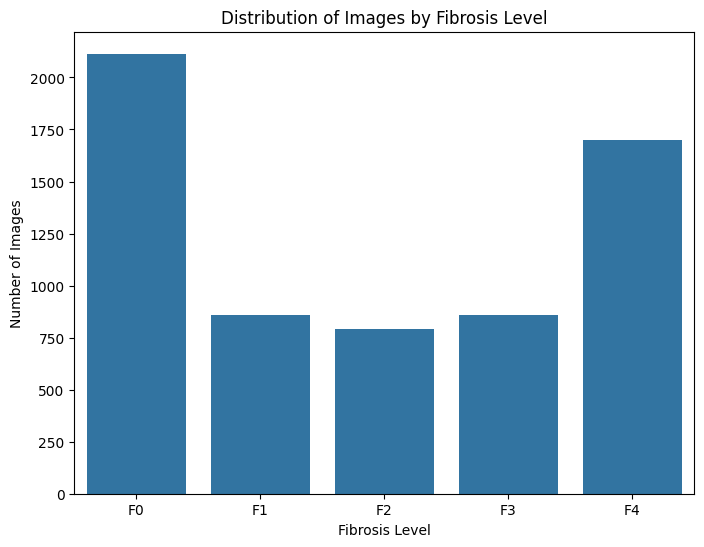

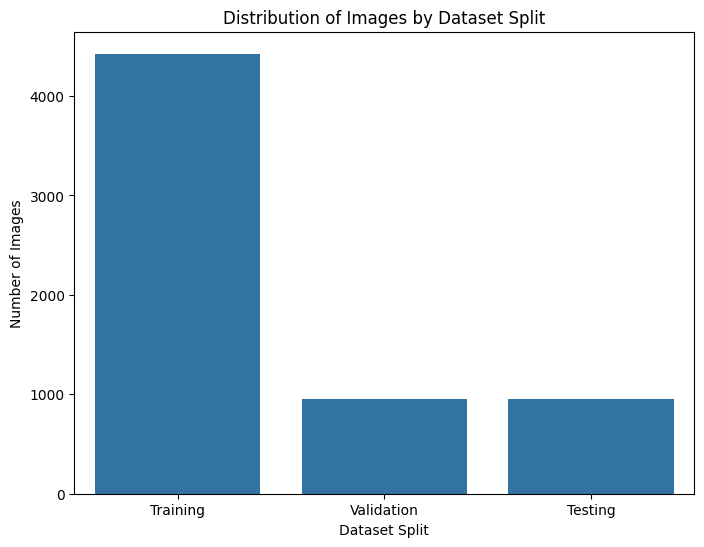

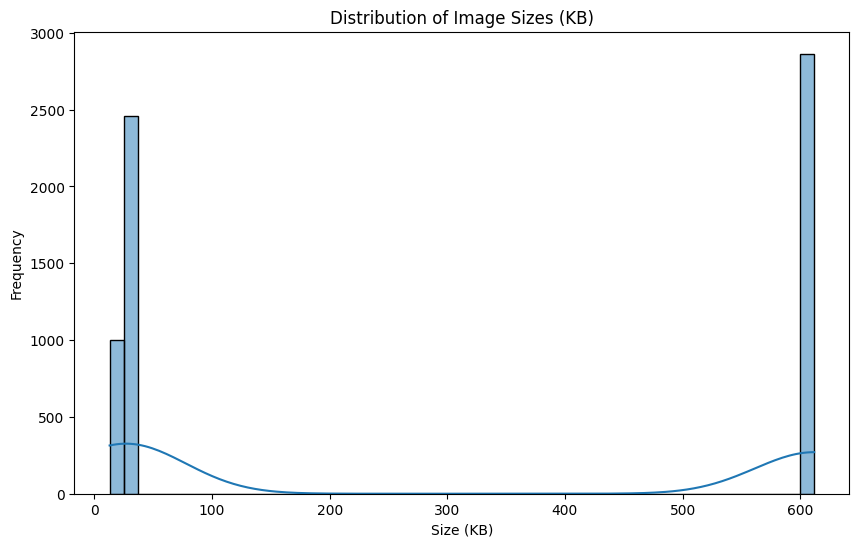

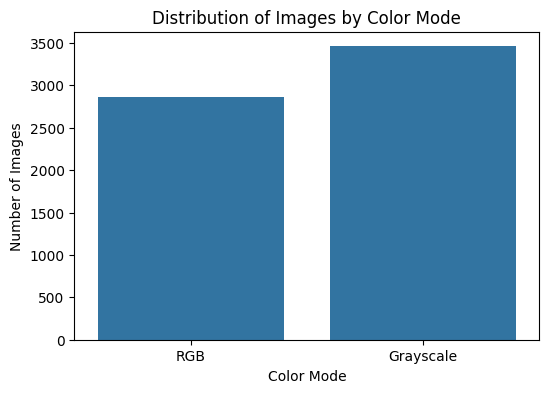

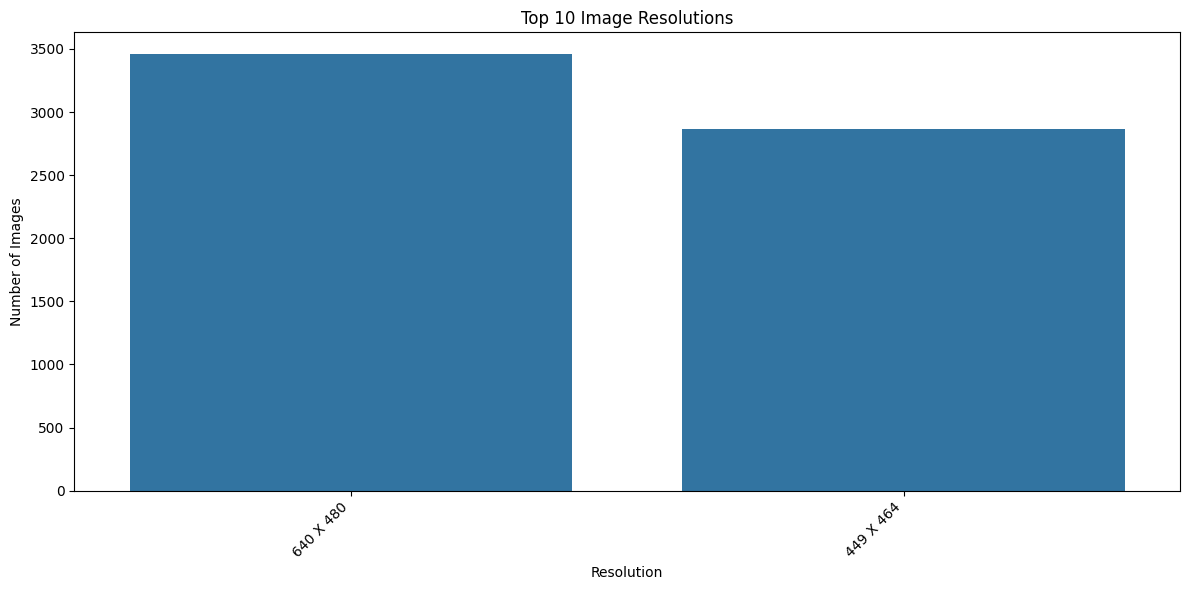

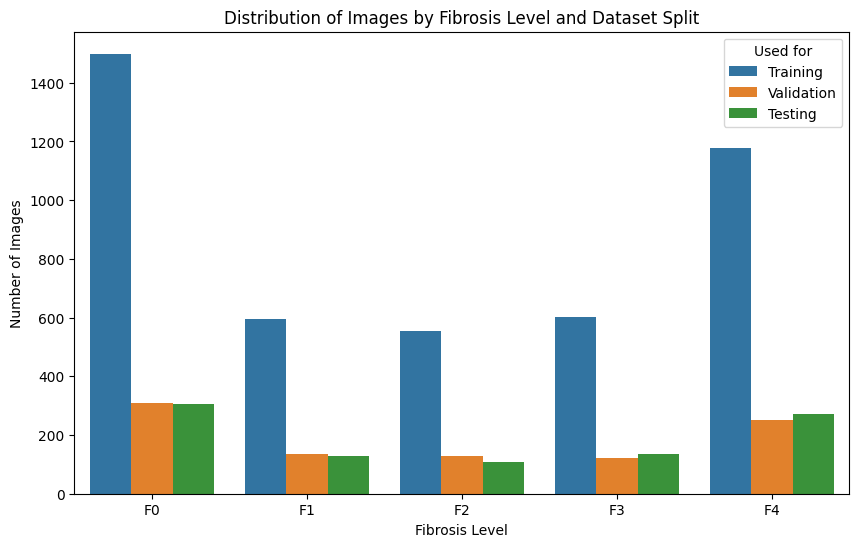

In [13]:
# prompt: Based on CSV file read, draw various chart from the object df_details.

# Assuming details_df DataFrame is already loaded from the CSV file
# df_details = pd.read_csv(CONFIG['labels_file']) # Uncomment this if details_df is not already in memory

# 1. Distribution of images by Label
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=details_df, order=sorted(details_df['Label'].unique()))
plt.title('Distribution of Images by Fibrosis Level')
plt.xlabel('Fibrosis Level')
plt.ylabel('Number of Images')
plt.show()

# 2. Distribution of images by Usage (Train, Validation, Test)
plt.figure(figsize=(8, 6))
sns.countplot(x='Used for', data=details_df, order=['Training', 'Validation', 'Testing'])
plt.title('Distribution of Images by Dataset Split')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.show()

# 3. Distribution of image sizes (Kernel Density Estimate plot)
plt.figure(figsize=(10, 6))
sns.histplot(details_df['Size (KB)'], bins=50, kde=True)
plt.title('Distribution of Image Sizes (KB)')
plt.xlabel('Size (KB)')
plt.ylabel('Frequency')
plt.show()

# 4. Distribution of images by Grayscale/RGB
plt.figure(figsize=(6, 4))
sns.countplot(x='Grayscale/RGB', data=details_df)
plt.title('Distribution of Images by Color Mode')
plt.xlabel('Color Mode')
plt.ylabel('Number of Images')
plt.show()

# 5. Distribution of images by Resolution (Top N resolutions)
# Count occurrences of each resolution
resolution_counts = details_df['Resolution'].value_counts().reset_index()
resolution_counts.columns = ['Resolution', 'Count']

# Display top 10 resolutions (adjust as needed)
top_n_resolutions = 10
plt.figure(figsize=(12, 6))
sns.barplot(x='Resolution', y='Count', data=resolution_counts.head(top_n_resolutions))
plt.title(f'Top {top_n_resolutions} Image Resolutions')
plt.xlabel('Resolution')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# 6. Count of images by Label and Usage
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', hue='Used for', data=details_df, order=sorted(details_df['Label'].unique()), hue_order=['Training', 'Validation', 'Testing'])
plt.title('Distribution of Images by Fibrosis Level and Dataset Split')
plt.xlabel('Fibrosis Level')
plt.ylabel('Number of Images')
plt.show()

## Load dataset

In [14]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False)



In [22]:
# prompt: Write code to extract each file name present in 'test_dataset' object and add them in "test_dataset.zip" bundle.
import zipfile
def test_datset_zip_file_create():
  # Get the list of file paths in the test_dataset
  test_file_paths = [test_dataset.samples[i][0] for i in test_dataset.indices]
  print(test_file_paths)
  # Define the name for the zip file
  zip_filename = "test_dataset.zip"

  # Create a ZipFile object in write mode
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
      # Add each file from the test_file_paths list to the zip file
      for file_path in test_file_paths:
          # The arcname is the name the file will have inside the zip archive.
          # We use os.path.basename to keep just the file name.
          zipf.write(file_path, arcname=os.path.basename(file_path))

  print(f"Created zip file: {zip_filename}")
  print(f"Number of files added to zip: {len(test_file_paths)}")

#Training

## Setup model

In [16]:
# Class labels
class_names =  CONFIG["class_labels"]
num_classes = len(class_names)

# Model
model = models.densenet121(pretrained=False)
device = CONFIG['device']

In [17]:
# Load the RadImageNet pretrained state_dict
state_dict = torch.load(CONFIG["pretrained_model_path"], map_location=CONFIG['device'])
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, CONFIG["num_classes"])
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

# Early stopping parameters
best_val_loss = float('inf')
patience_counter = 0

In [32]:
train_loader

## Train the model

In [33]:
# Training and Validation Loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
train = CONFIG['train']

if train == True:
  for epoch in range(CONFIG['num_epochs']):
      model.train()
      train_loss, correct_train = 0, 0

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          preds = torch.argmax(outputs, dim=1)
          correct_train += torch.sum(preds == labels)

      train_loss /= len(train_loader)
      train_accuracy = correct_train.double() / len(train_loader.dataset)
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy.item())

      # Validation
      model.eval()
      val_loss, correct_val = 0, 0
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              preds = torch.argmax(outputs, dim=1)
              correct_val += torch.sum(preds == labels)

      val_loss /= len(val_loader)
      val_accuracy = correct_val.double() / len(val_loader.dataset)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy.item())

      print(f"Epoch {epoch+1}/{CONFIG['num_epochs']} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

      # Early Stopping
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
          torch.save(model.state_dict(), CONFIG['output_model_path'])
      else:
          patience_counter += 1
          if patience_counter >= CONFIG['training_patience']:
              print("Early stopping triggered.")
              break



Epoch 1/2 - Train Loss: 1.2334, Val Loss: 1.0890, Train Acc: 0.4704, Val Acc: 0.5032
Epoch 2/2 - Train Loss: 1.0478, Val Loss: 0.9681, Train Acc: 0.5465, Val Acc: 0.6002


# Model Evaluation

## Plot training/validation metrics

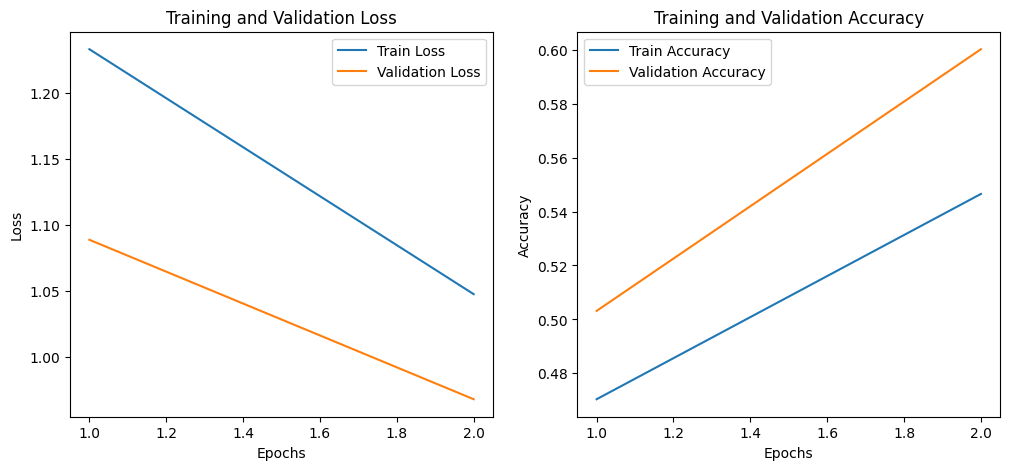

In [34]:


# Plot Training and Validation Metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



In [35]:
# prompt: Generate code to save the training and validation accuracy and loss details in a JSON file so that it can be plotted later.

import json

# Data to be saved
training_metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}

# File path to save the JSON
json_file_path = CONFIG["training_metrics_json"]

# Save the data to a JSON file
with open(json_file_path, 'w') as f:
    json.dump(training_metrics, f)

print(f"Training metrics saved to {json_file_path}")

Training metrics saved to training_metrics.json


## Evaluation and metric generation

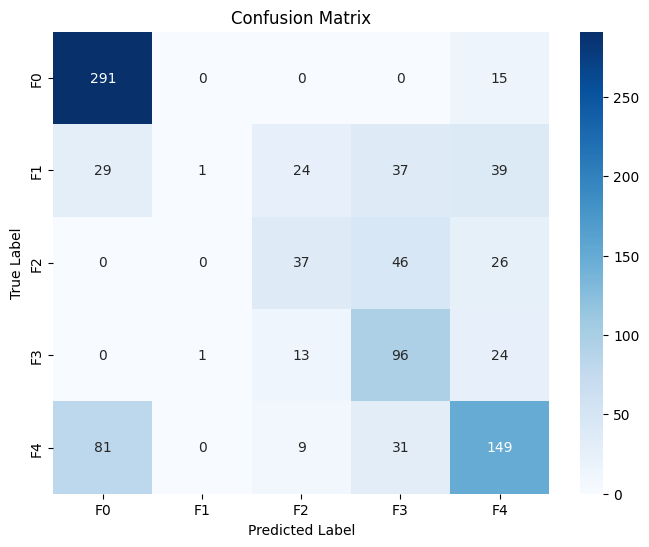

              precision    recall  f1-score   support

          F0       0.73      0.95      0.82       306
          F1       0.50      0.01      0.02       130
          F2       0.45      0.34      0.39       109
          F3       0.46      0.72      0.56       134
          F4       0.59      0.55      0.57       270

    accuracy                           0.60       949
   macro avg       0.54      0.51      0.47       949
weighted avg       0.59      0.60      0.55       949



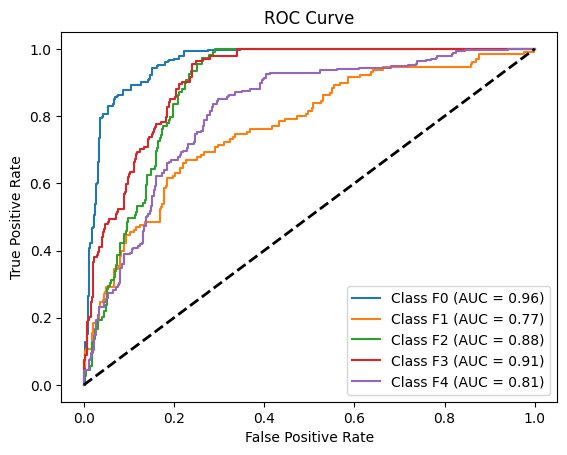

Training Complete. Model evaluation and plots generated.


In [36]:
# Evaluation on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix with Counts
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))

# ROC Curve
all_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = torch.softmax(model(inputs), dim=1)
        all_probs.extend(outputs.cpu().numpy())

all_labels_onehot = np.eye(num_classes)[all_labels]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_onehot[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

print("Training Complete. Model evaluation and plots generated.")

In [37]:
# prompt: Generate code to store the classification metrics and confusion matrix details, ROC/AUC curve details in a JSON file so that these can be regenerated later.

# Store evaluation metrics and ROC/AUC data in a JSON file

# Get the classification report as a dictionary
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

# Convert numpy arrays from ROC curve to lists for JSON serialization
fpr_list = {str(i): list(fpr[i]) for i in range(num_classes)}
tpr_list = {str(i): list(tpr[i]) for i in range(num_classes)}

# Store the evaluation metrics and ROC/AUC data in a dictionary
evaluation_metrics = {
    'confusion_matrix': cm.tolist(), # Convert numpy array to list
    'classification_report': report,
    'roc_curve': {
        'fpr': fpr_list,
        'tpr': tpr_list,
        'auc': roc_auc
    },
    'class_names': class_names
}

# Define the file path to save the JSON
evaluation_json_file_path = 'evaluation_metrics.json' # You can define this in CONFIG if you prefer

# Save the evaluation metrics to a JSON file
with open(evaluation_json_file_path, 'w') as f:
    json.dump(evaluation_metrics, f, indent=4) # Use indent for readability

print(f"Evaluation metrics saved to {evaluation_json_file_path}")


Evaluation metrics saved to evaluation_metrics.json


# Inference

In [23]:
import torch
import torch.nn as nn
from torchvision import models

# Load a pre-trained DenseNet121 model
model = models.densenet121(weights=False) # Set pretrained to False initially

# Get the number of input features for the classifier layer
num_ftrs = model.classifier.in_features

# Replace the classifier layer to match the number of classes in your dataset
# Assuming CONFIG['num_classes'] holds the correct number of classes (which is 5 based on the error)
model.classifier = nn.Linear(num_ftrs, CONFIG['num_classes'])

# Load the best model / uploaded model
# Ensure map_location is correctly set if you are loading a GPU-trained model on CPU or vice-versa
model.load_state_dict(torch.load(CONFIG["output_model_path"], map_location=CONFIG['device']))

# Move the model to the device
model = model.to(CONFIG['device'])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RuntimeError: Error(s) in loading state_dict for DenseNet:
	size mismatch for classifier.weight: copying a param with shape torch.Size([3, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([5]).

## Inference with grad-cam

In [20]:

#!pip install pytorch-gradcam
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.7 MB/s

In [ ]:
print(model)

In [22]:
from google.colab import files
from PIL import Image
import io
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


# Helper function to apply heatmap
def apply_gradcam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    img = np.array(img.resize((CONFIG['image_size'], CONFIG['image_size']))) / 255.0
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# Grad-CAM++ using pytorch-grad-cam
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

def get_gradcampp_heatmap(model, input_tensor, target_class, target_layer):
    cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])
    targets = [ClassifierOutputTarget(target_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    return grayscale_cam[0]


# Updated prediction function with Grad-CAM++
def predict_uploaded_image(model, transform, class_names, target_layer):
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f'User uploaded file "{filename}"')

        orig_img = Image.open(io.BytesIO(uploaded[filename])).convert('RGB')

        img_t = transform(orig_img)
        batch_t = torch.unsqueeze(img_t, 0).to(device)

        model.eval()
        with torch.no_grad():
            out = model(batch_t)
            probabilities = torch.softmax(out, dim=1)
            percentage = probabilities[0] * 100
            _, index = torch.max(out, dim=1)
            print(index.item())
            predicted_class = class_names[index.item()]

        print(f"Predicted class: {predicted_class}")

        plt.figure(figsize=(8, 5))
        sns.barplot(x=class_names, y=percentage.cpu().numpy())
        plt.title('Probability Distribution')
        plt.xlabel('Class')
        plt.ylabel('Probability (%)')
        plt.ylim(0, 100)
        plt.show()

        heatmap = get_gradcampp_heatmap(model, batch_t, index.item(), target_layer)
        cam_img = apply_gradcam_on_image(orig_img, heatmap)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(orig_img)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(cam_img)
        axes[1].set_title('Grad-CAM++ Visualization')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        return predicted_class, probabilities.cpu().numpy()[0]

inference_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

target_layer = model.features.norm5
#class_names = ['F0', 'F1', 'F2', 'F3', 'F4']

predicted_class, probabilities = predict_uploaded_image(model, inference_transform, CONFIG["class_labels"], target_layer)


Saving h2824.jpg to h2824.jpg
User uploaded file "h2824.jpg"


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [1]:
# Extract metrics from the classification report dictionary
report_data = []
for class_name, metrics in report.items():
    # Exclude 'accuracy', 'macro avg', and 'weighted avg' which are not class-specific
    if class_name in class_names:
        report_data.append({
            'Class': class_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-score': metrics['f1-score'],
            'Support': metrics['support']
        })

report_df = pd.DataFrame(report_data)

# Plotting the metrics
metrics_to_plot = ['Precision', 'Recall', 'F1-score', 'Support']

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Class', y=metric, data=report_df, order=class_names)
    plt.title(f'{metric} by Class')
    plt.xlabel('Class')
    plt.ylabel(metric)
    plt.ylim(0, 1 if metric != 'Support' else max(report_df['Support']) * 1.1) # Adjust y-limit for Support
    plt.show()

NameError: name 'report' is not defined

# Streamlit App


In [ ]:
!pip install streamlit

In [ ]:
 !streamlit run  /content/sample_data/dashboard.py

In [ ]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import json
import os
from glob import glob
import random

st.set_page_config(page_title="Liver Fibrosis Dashboard")

# Sidebar menu
section = st.sidebar.radio("Navigation", [
    "Project Overview",
    "Data Summary",
    "Training Metrics",
    "Evaluation Report",
    "Live Inference"
])

# Load cached training/evaluation stats
@st.cache_data

def load_training_stats():
    try:
        return pd.read_json("training_stats.json")
    except:
        return None

@st.cache_data

def load_eval_report():
    try:
        with open("eval_report.json") as f:
            return json.load(f)
    except:
        return None

training_df = load_training_stats()
eval_report = load_eval_report()

# Section: Project Overview
if section == "Project Overview":
    st.title("Liver Fibrosis Classification Dashboard")
    st.markdown("""
    This Streamlit app presents a complete pipeline for classifying liver fibrosis
    stages (F0 to F4) using ultrasound images.

    **Features:**
    - Data distribution and sample images
    - Training and validation performance tracking
    - Evaluation metrics and confusion matrix
    - Upload and test your own ultrasound image
    """)

# Section: Data Summary
elif section == "Data Summary":
    st.title("Dataset Summary")
    if training_df is not None:
        st.subheader("Class Distribution")
        fig1, ax1 = plt.subplots()
        sns.countplot(x="Label", data=training_df, ax=ax1, order=sorted(training_df['Label'].unique()))
        st.pyplot(fig1)
    else:
        st.warning("Training data statistics not available.")

# Section: Training Metrics
elif section == "Training Metrics":
    st.title("Training Progress")
    if training_df is not None:
        st.subheader("Loss over Epochs")
        st.line_chart(training_df[['train_loss', 'val_loss']])

        st.subheader("Accuracy over Epochs")
        st.line_chart(training_df[['train_acc', 'val_acc']])
    else:
        st.warning("Training metrics not found.")

# Section: Evaluation Report
elif section == "Evaluation Report":
    st.title("Model Evaluation")
    if eval_report is not None:
        st.markdown(f"### Test Accuracy: **{eval_report['accuracy']*100:.2f}%**")

        st.subheader("Classification Report")
        st.json(eval_report['classification_report'])

        st.subheader("Confusion Matrix")
        cm = np.array(eval_report['confusion_matrix'])
        fig2, ax2 = plt.subplots()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=eval_report['classes'], yticklabels=eval_report['classes'])
        st.pyplot(fig2)
    else:
        st.warning("Evaluation report not available.")

# Section: Live Inference
elif section == "Live Inference":
    st.title("Try It Out: Upload or Select an Image")

    class_labels = ['F0', 'F1', 'F2', 'F3', 'F4']

    def load_model():
        model = models.densenet121(weights=False)
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, len(class_labels))
        )
        model.load_state_dict(torch.load("best_model.pt", map_location="cpu", weights_only=True))
        model.eval()
        return model

    def preprocess_image(image):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
        return transform(image.convert('RGB')).unsqueeze(0)

    model = load_model()

    selected_image = None

    # Enhanced grid layout with image selection using button under each image
    st.subheader("🔍 Select from Preloaded Images")
    preloaded_images = []
    preloaded_captions = []
    img_dir = "Fibrosis_Dataset/Dataset/Validation"
    for cls in class_labels:
        files = (glob(f"{img_dir}/{cls}/*.jpg") + glob(f"{img_dir}/{cls}/*.png"))
        for idx, file in enumerate(files):
            preloaded_images.append(file)
            preloaded_captions.append(f"{cls} - {idx+1}")

    selected_image = None
    grid_cols = 5
    grid_rows = len(preloaded_images) // grid_cols
    for row in range(grid_rows):
        cols = st.columns(grid_cols)
        for i in range(grid_cols):
            idx = row * grid_cols + i
            if idx < len(preloaded_images):
                with cols[i]:
                    #st.image(preloaded_images[idx], caption=preloaded_captions[idx], width=120)
                    st.image(preloaded_images[idx],  width=120)
                    if st.button(preloaded_captions[idx]):
                        selected_image = preloaded_images[idx]
                        st.session_state.selected_image = selected_image

    uploaded_file = st.file_uploader("Or Upload Your Own Ultrasound Image", type=["jpg", "jpeg", "png"])
    image = None
    if uploaded_file:
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Image", use_container_width =True)
    elif "selected_image" in st.session_state:
        selected_image = st.session_state.selected_image
        image = Image.open(selected_image)
        st.image(image, caption=f"Selected Image ({selected_image})", use_container_width =True)

    if image is not None:
        input_tensor = preprocess_image(image)
        with torch.no_grad():
            output = model(input_tensor)
            probs = torch.nn.functional.softmax(output[0], dim=0).numpy()
            pred_idx = np.argmax(probs)
            pred_label = class_labels[pred_idx]

        st.markdown(f"### Predicted Class: **{pred_label}**")

        st.subheader("Class Probabilities")
        prob_df = pd.DataFrame({
            "Class": class_labels,
            "Probability (%)": probs * 100
        })
        colors = ["#1f77b4"] * len(class_labels)
        colors[pred_idx] = "#ff7f0e"
        fig3, ax3 = plt.subplots()
        bars = ax3.bar(prob_df['Class'], prob_df['Probability (%)'], color=colors)
        ax3.set_ylabel("Probability (%)")
        ax3.set_ylim(0, 100)

        # Add probability values on top of each bar
        for bar, prob in zip(bars, prob_df['Probability (%)']):
            height = bar.get_height()
            ax3.annotate(f"{prob:.1f}%",
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)

        st.pyplot(fig3)


        # --- Optional: Grad-CAM visualization ---
        ENABLE_GRADCAM = True
        #if ENABLE_GRADCAM:
        #    st.markdown("#### Grad-CAM Visualization (optional)")
        #    st.info("Grad-CAM logic would go here.")

        # --- Optional: Inference Logging ---
        ENABLE_LOGGING = True
        if ENABLE_LOGGING:
            log_entry = {
                "image": uploaded_file.name if uploaded_file else selected_image,
                "prediction": pred_label,
                "probabilities": probs.tolist()
            }
            with open("inference_log.jsonl", "a") as f:
                f.write(json.dumps(log_entry) + "\n")
    else:
        st.info("Please select or upload an image to begin inference.")
